> # TME 1 : Problèmes de Bandits
LIAUTAUD Paul M2A_2021

This first practical work is dedicated to put the light on some naive methods at the very beginning. Then, we will emphasize important "bandits" methods and algorithms as presented during the course that took place on the *20th September 2021*.

In [16]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import re
from math import *
import random
import numpy as np
%matplotlib inline

## Reading `CTR.txt` file via `pandas`

In [20]:
df = pandas.read_csv("/Users/paulliautaud/Desktop/OneDrive/Documents/M2_M2A/RL/RLD/Dataset/CTR.txt", sep=':|;',header=None, engine = "python") #le "|" permet de rajouter un séparateur

In [21]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')

In [22]:
representation = df.iloc[:,1:6]
CTR = df.iloc[:,6:16] #save the 10 arms rates at each time (line)

## Baseline (aka naive method)

### Random selection via `randint`

In [23]:
rando = []
for k in range(5000):
    rando.append(CTR.loc[k,np.random.randint(6,16)])

Text(0.5, 1.0, 'Random selection')

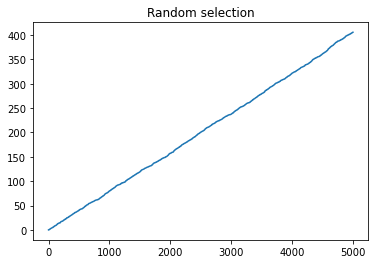

In [24]:
plt.plot(np.cumsum(rando))
plt.title("Random selection")

### StaticBest selection

Here the principle is to elect the greatest CTR (regarding its final rate sum) and to plot its cumulated click rate.

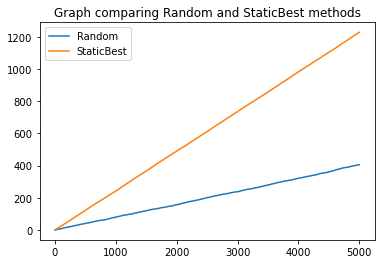

In [25]:
#Affichage de la somme cumulée de la colonne au meilleur taux CTR :
sup = 6
total = df[6].sum()
for k in range(7,16) :
    if total < df[k].sum():
        total = df[k].sum()
        sup = k

static_best = CTR.iloc[:,sup]
plt.plot(np.cumsum(rando),label='Random')
plt.plot(np.cumsum(static_best), label='StaticBest')
plt.title("Graph comparing Random and StaticBest methods")
plt.legend()

### Optimal selection

Here the main idea is to spot the best CTR at each time $t$ from $t=1$ to $t=5000$.

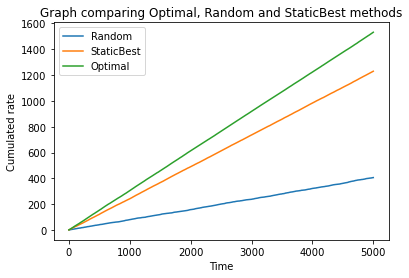

In [26]:
opti = np.cumsum(CTR.max(axis=1)) #cumulated sum of greatest rates over the dataframe lines
plt.plot(np.cumsum(rando),label='Random')
plt.plot(np.cumsum(static_best), label='StaticBest')
plt.plot(opti, label = 'Optimal')
plt.title('Graph comparing Optimal, Random and StaticBest methods')
plt.xlabel('Time')
plt.ylabel('Cumulated rate')
plt.legend()

# A first bandit method : the $\epsilon$-greedy algorithm

For iterative and cumulative actions on a type of objects, it is common to create ``class`` and to use several ``methods`` acting on its objects. Here one can create the following to perform the $\epsilon$-greedy algorithm :

In [27]:
class e_greedy():
    def __init__(self, epsilon = 0.05, counts = [], values = [], n_arms = 0):
        """ Collect parameters when setting an object """
        self.epsilon = epsilon
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
    
    def select_arm(self):
        """ Elect the arm whose score value is the greatest when random.random() > eps, otherwise  (random/uniform) exploration in arms list""" 
        if sum(self.values) == 0: #initialisation
            return int(np.random.randint(len(self.values)))
        else:
            return self.values.index(max(self.values)) if np.random.random() > self.epsilon else int(np.random.randint(len(self.values)))
        
    def update(self, chosen_arm, reward):
        """ Update the self.values list according to rewards """
        self.counts[chosen_arm] += 1
        new_value = ((self.counts[chosen_arm] - 1) /float(self.counts[chosen_arm])) * self.values[chosen_arm] + (1 / float(self.counts[chosen_arm])) * reward
        self.values[chosen_arm] =  new_value
        

#Simulation
def epsilongreedy(sample_size, epsilon):
    algo = e_greedy(epsilon,[],[], 10)  #initialisation using the e_greedy class initialiser
    i = 0
    vector_arms_chosen = []
    reward_vect = []
    reward_cum = 0
    while i < sample_size :
        chosen_arm = algo.select_arm()
        vector_arms_chosen.append(chosen_arm)
        reward = CTR.iloc[i, chosen_arm]
        algo.update(chosen_arm, reward)
        reward_cum += reward
        if i != 0:
            reward_vect.append(reward_cum) #cumumated reward
            #reward_vect.append(reward_cum / float(i)) #average cumulated reward
        else:
            reward_vect.append(0)
        i += 1
    return reward_vect, algo.values, algo.counts, vector_arms_chosen


#Features
sample_size = 5000
epsilon = 0.25

#Execution
rewards_vect, values, count, arms_chosen = epsilongreedy(sample_size, epsilon)

Text(0.5, 1.0, 'Cumulated number of draws for each arm with $\\epsilon$-greedy')

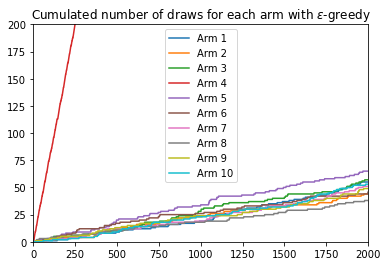

In [28]:
#Cumulated sum of arms_chosen
cum_sum_arm = [[0] for k in range(10)]
for ele in arms_chosen :
    for k in range(10) :
        cum_sum_arm[k].append(cum_sum_arm[k][-1])
    cum_sum_arm[ele][-1]+=1

label = []
for k in range(10):
    plt.plot(range(sample_size+1),cum_sum_arm[k])
    plt.axis([0,2000,0,200])
    label.append(f'Arm {k+1}')
    plt.legend(label)
plt.title(r"Cumulated number of draws for each arm with $\epsilon$-greedy")

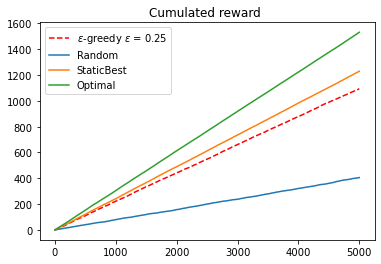

In [29]:
#Reward graph
plt.plot(range(sample_size), rewards_vect, 'r--', label = r"$\epsilon$-greedy $\epsilon$ = %s" % epsilon);
plt.plot(np.cumsum(rando),label='Random')
plt.plot(np.cumsum(static_best), label='StaticBest')
plt.plot(opti, label = 'Optimal')
plt.title("Cumulated reward ");
plt.legend(loc="upper left");

# Let's move on the Upper Confidence Bound algorithm

Also famous, it is the second type of "bandits" algorithm (jointly with the $\epsilon$-greedy).
It consists of the following steps :
 1. For initialisation, each arm will be taken into account and the program will save the rate as a starting mean point.
 2. For each time $i \geq 10$ after the ten first iterations (initialisation) :
     - We compute the **upper confidence bound** for a given advertiser among the ten : $$B_{t,T_i}(i) = \hat{\mu}_{t,s} + \sqrt{\dfrac{2 \ln(t)}{T_i}},$$ where $\hat{\mu}_{t,s}$ is the empirical rate of clicks for the advertiser $t$ during $T_i$ selections over $i$ times.
     - We recommand the advertiser whose the upper confidence bound is the the greatest until the end of the list.
     
Again, we will build an "UCB" ``class`` with parameters and methods we will call during the iterations/

In [30]:
#Initialisation
#Sur les 10 premières itérations on tire de façon déterministe chacun des bras pour pouvoir initialiser nos valeurs
rate = np.zeros(10) #taux sélectionnés
mu = np.zeros(10) #moyenne des taux
s = np.zeros(10) #nombre d'utilisation des bras
B = np.zeros(10)
t=10
for k in range(10):
    rate[k]=CTR.loc[k,k+6]
    s[k]+=1
    mu[k]=rate[k]/s[k]
    B[k]=mu[k]+np.sqrt(np.log(2)/s[k])

for k in range(10,5000):
    best = np.argmax(B)
    mu[best] = CTR.loc[k,best]

In [31]:
class UCB():
    def __init__(self, counts = [], values = [], n_arms = 0):
        self.counts = [0 for arm in range(n_arms)]
        self.values = [0.0 for arm in range(n_arms)]
        self.n_arms = n_arms
    
    def select_arm(self):
        """ Select the best arm (with the greatest upper bound) """
        for arm in range(self.n_arms): 
            if self.counts[arm] == 0:  #initialisation
                return arm
        ucb_values = [0.0 for arm in range(self.n_arms)]
        total_counts = sum(self.counts)
        for arm in range(self.n_arms):
            new = np.sqrt((2*np.log(total_counts))/float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + new #the upper bound may fluctuate here for each arm
        #value_max = max(ucb_values)
        return np.argmax(ucb_values) #return the arm with greatest UCB

    def update(self, chosen_arm, reward):
        """ Update the values list of the empirical means for each arms at each loop step """
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) /float(n)) * value + (1 / float(n)) * reward #update of the empirical rate
        self.values[chosen_arm] =  new_value
        
        
#Simu
def UCB_advert(sample_size):
    #initialisation
    vector_arms_chosen = []
    reward_vect = []
    reward_cum = 0
    algo = UCB([],[], 10) #initialisation using the UCB class builder
    
    i = 0
    while i < sample_size :
        chosen_arm = algo.select_arm()
        vector_arms_chosen.append(chosen_arm)
        reward = CTR.iloc[i, chosen_arm] #the arm is chosen thanks to the select_arm method in UCB class
        algo.update(chosen_arm, reward)
        reward_cum = reward_cum + reward
        i += 1
        reward_vect.append(reward_cum) #average cumulated empirical mean
    return reward_vect, algo.values, algo.counts, vector_arms_chosen


#Execution
sample_size2 = 5000
rewards_vect2, values2, count2, arms_chosen2 = UCB_advert(sample_size2)

Text(0.5, 1.0, 'Cumulated number of draws for each arm for UCB')

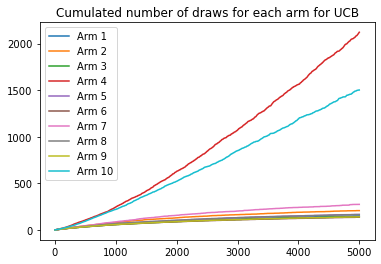

In [32]:
#Building the cumulated arms_chosen list
cum_sum_arm2 = [[0] for k in range(10)]
for ele in arms_chosen2 :
    for k in range(10) :
        cum_sum_arm2[k].append(cum_sum_arm2[k][-1])
    cum_sum_arm2[ele][-1]+=1

label = []
for k in range(10):
    plt.plot(range(sample_size+1),cum_sum_arm2[k])
    label.append(f'Arm {k+1}')
    plt.legend(label)
plt.title("Cumulated number of draws for each arm for UCB")

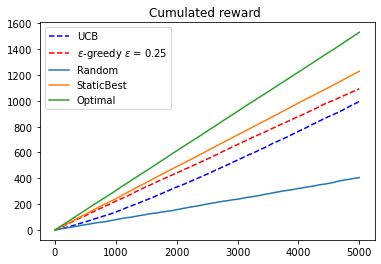

In [33]:
#Graph comparing rewards for each algo

plt.plot(range(sample_size), rewards_vect2, 'b--', label = "UCB");
plt.plot(range(sample_size), rewards_vect, 'r--', label = r"$\epsilon$-greedy $\epsilon$ = %s" % epsilon);
plt.plot(np.cumsum(rando),label='Random')
plt.plot(np.cumsum(static_best), label='StaticBest')
plt.plot(opti, label = 'Optimal')
plt.title("Cumulated reward ");
plt.legend(loc="upper left");

## Taking variance of rewards when computin upper bounds : UCB-V

Up to now, we compute upper bounds with the mean rewards for each arm. This can be upgraded as follows.

Indeed, we can quickly implement a variant of UCB, called UCB-V and that uses the squares of the rewards to estimate the variance of each arm and calculate a better confidence interval. This allows to take into account the varirabily of each arm based of the variance of the rewards they get.
We introduce the empirical variance as: $$\hat \sigma_{i,n}^2 = \frac 1 n \sum_{s=1}^n(g_{i,s} - \hat \mu_{i,n})^2.$$

The **upper confidence bound** is now computed using $\hat \sigma$:$$B_{t,T_i}(i) = \hat{\mu}_{t,T_i} + \sqrt{\dfrac{2 \ln(t)\hat \sigma_{i,T_i}^2}{T_i}} + \frac {\ln(
t)}{2T_i},$$ where $\hat{\mu}_{t,T_i}$ is the empirical rate of clicks for the advertiser $t$ during $T_i$ selections over $i$ times.

In [43]:
class UCBV():
    def __init__(self, counts = [], values = [], n_arms = 0):
        self.counts = [0 for arm in range(n_arms)]
        self.values = [0.0 for arm in range(n_arms)]
        self.n_arms = n_arms
    
    def select_arm(self):
        """ Select the best arm (with the greatest upper bound) """
        for arm in range(self.n_arms): 
            if self.counts[arm] == 0:  #initialisation
                return arm
        ucb_values = [0.0 for arm in range(self.n_arms)]
        total_counts = sum(self.counts)
        for arm in range(self.n_arms):
            v = np.var(self.values[arm]) #empirical variance
            new = np.sqrt((2*np.log(total_counts)*v)/float(self.counts[arm])) + np.log(total_counts)/(2*float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + new #the upper bound may fluctuate here for each arm
        #value_max = max(ucb_values)
        return np.argmax(ucb_values) #return the arm with greatest UCB

    def update(self, chosen_arm, reward):
        """ Update the values list of the empirical means for each arms at each loop step """
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) /float(n)) * value + (1 / float(n)) * reward #update of the empirical rate
        self.values[chosen_arm] =  new_value

In [44]:
#Simu
def UCB_advert_2(sample_size):
    #initialisation
    vector_arms_chosen = []
    reward_vect = []
    reward_cum = 0
    algo = UCBV([],[], 10) #initialisation using the UCB class builder
    
    i = 0
    while i < sample_size :
        chosen_arm = algo.select_arm()
        vector_arms_chosen.append(chosen_arm)
        reward = CTR.iloc[i, chosen_arm] #the arm is chosen thanks to the select_arm method in UCB class
        algo.update(chosen_arm, reward)
        reward_cum = reward_cum + reward
        i += 1
        reward_vect.append(reward_cum) #average cumulated empirical mean
    return reward_vect, algo.values, algo.counts, vector_arms_chosen


#Execution
sample_size_UCBV = 5000
rewards_vect_UCBV, values_UCBV, countUCBV, arms_chosen_UCBV = UCB_advert_2(sample_size_UCBV)

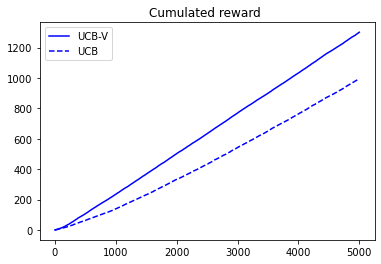

In [46]:
#Graphs
plt.plot(range(sample_size), rewards_vect_UCBV, 'b', label = "UCB-V");
plt.plot(range(sample_size), rewards_vect2, 'b--', label = "UCB");
#plt.plot(range(sample_size), rewards_vect, 'r--', label = r"$\epsilon$-greedy $\epsilon$ = %s" % epsilon);
#plt.plot(np.cumsum(rando),label='Random')
#plt.plot(np.cumsum(static_best), label='StaticBest')
#plt.plot(opti, label = 'Optimal')
plt.title("Cumulated reward ");
plt.legend(loc="upper left");

#  A more contextual "bandits" approach : the LinUCB algorithm

Up to now, we show that there exists a notable dilemma of choosing between *exploration* and *exploitation*. The key is then to strike the balance between trying out new falvours (this is *exploration*) and always getting the favourite (we talk about *exploitation*). The problem with classical UCB algorithm is that it doesn't take into account neither the *user* nor the *content features* (i.e. the context) that may include the user's historical activites (at an aggregated level).
The exploitation/exploration problem that takes into account contextual features is formalised as follows, for each trial $t$ :
 1. The algorithm observes tge current user and a set $\mathcal A_t$ of arms together with their feature vectors $\mathbf {x}_{t,a}$ for $a \in \mathcal A_t$. The vector $\mathbf x_{t,a}$ summarizes information of both the user and arm $a$ and will be referred to as the *context*.
 2. Based on observed payoffs (rewards) in previous trials, the algorithm chooses and arm $a_t \in \mathcal A_t$ and receives payoff $r_{t,a_t}$ whose expectation depends on both the user and the arm $a_t$. The expected payoff of an arm is assumed to be linear in its $d$- dimensional feature vector $\mathbf x$ with some unknown coefficient vector $\theta$ : $$\mathbb{E} [r_{t,a}|\mathbf x_{t,a}] = \mathbf x_{t,a}^\top\mathbf \theta^*_a.$$ Then to solve for the coefficient vector $\mathbf \theta^*$ in the above equation, we applu ridge regression to the training data.
 3. Finally, the algorithm improves its arm-selection strategy with the new observation $(\mathbf x_{t,a}, a_t, r_{t,a_t})$ as follows : $$a_t = \underset{a \in \mathcal A_t}{\operatorname{arg max}} \left(\mathbf x^\top_{t,a} \hat{\mathbf \theta}_a + \alpha \sqrt{\mathbf x_{t,a}^\top A^{-1}_a \mathbf x_{t,a}}\right),$$ with $\alpha >0$.

In [47]:
#Extraction of the 5 context columns in df
context = df.iloc[:,1:6] #save the 5 dimensions of the article (contextual features)
LA = [np.eye(5)]*10

class LinUCB():
    def __init__(self, counts = [], values = [], A_matrices = [], b_vect = [], theta = [], p_values = [], n_arms = 0):
        self.counts = [0 for arm in range(n_arms)]
        self.values = [0.0 for arm in range(n_arms)]
        self.A_matrices = [np.eye(5)]*10
        self.b_vect = [np.zeros(5)]*10
        self.theta = [np.zeros(5)]*10
        self.p_values = [0.0 for arm in range(n_arms)]
        self.n_arms = n_arms
    
    def select_arm(self, context):
        """ Select the best arm (with the greatest upper bound) """
        for arm in range(self.n_arms): 
            if self.counts[arm] == 0:  #if a is new
                self.A_matrices[arm] = np.eye(5)
                self.b_vect[arm] = np.zeros(5)
            invA = np.linalg.inv(self.A_matrices[arm])
            self.theta[arm] = np.dot(invA,self.b_vect[arm])
            self.p_values[arm] = np.dot(self.theta[arm].T,context) + alpha*sqrt(np.dot(context.T,np.dot(invA,context)))
        return np.argmax(self.p_values)

    def update(self, chosen_arm, reward, context):
        """ Update the values list of the empirical means for each arms at each loop step """
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) /float(n)) * value + (1 / float(n)) * reward #update of the empirical rate
        self.values[chosen_arm] =  new_value
        self.A_matrices[chosen_arm] += np.dot(context, context.T)
        self.b_vect[chosen_arm] += reward*context
        

In [48]:
#Simu
def LinUCB_advert(sample_size):
    #initialisation
    vector_arms_chosen = []
    reward_vect = []
    reward_cum = 0
    algo = LinUCB(counts = [], values = [], A_matrices = [], b_vect = [], theta = [], p_values = [], n_arms=10) #initialisation using the LinUCB class builder
    i = 0
    while i < sample_size :
        chosen_arm = algo.select_arm(context.iloc[i,:].to_numpy())
        vector_arms_chosen.append(chosen_arm)
        reward = CTR.iloc[i, chosen_arm] #the arm is chosen thanks to the select_arm method in LinUCB class
        algo.update(chosen_arm, reward, context.iloc[i,:].to_numpy())
        reward_cum = reward_cum + reward
        i += 1
        reward_vect.append(reward_cum) #average cumulated empirical mean
    return reward_vect, algo.values, algo.counts, vector_arms_chosen

In [49]:
#Execution
alpha=0.95
sample_size3 = 5000
rewards_vect3, values3, count3, arms_chosen3 = LinUCB_advert(sample_size3)

Text(0.5, 1.0, 'Cumulated number of draws for each arm for LinUCB')

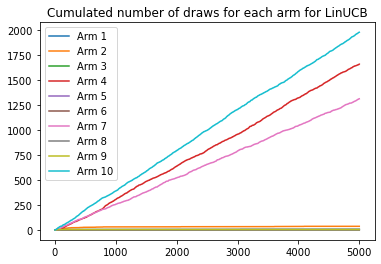

In [50]:
#Building the cumulated arms_chosen list
cum_sum_arm3 = [[0] for k in range(10)]
for ele in arms_chosen3 :
    for k in range(10) :
        cum_sum_arm3[k].append(cum_sum_arm3[k][-1])
    cum_sum_arm3[ele][-1]+=1

label = []
for k in range(10):
    plt.plot(range(sample_size+1),cum_sum_arm3[k])
    label.append(f'Arm {k+1}')
    plt.legend(label)
plt.title("Cumulated number of draws for each arm for LinUCB")

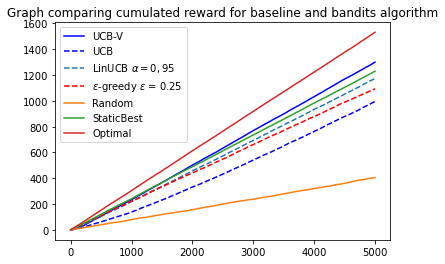

In [53]:

plt.plot(range(sample_size2), rewards_vect_UCBV, 'b', label = "UCB-V");
plt.plot(range(sample_size2), rewards_vect2, 'b--', label = "UCB");
plt.plot(range(sample_size3), rewards_vect3, '--', label = r"LinUCB $\alpha = 0,95$")
plt.plot(range(sample_size), rewards_vect, 'r--', label = r"$\epsilon$-greedy $\epsilon$ = %s" % epsilon);
plt.plot(np.cumsum(rando),label='Random')
plt.plot(np.cumsum(static_best), label='StaticBest')
plt.plot(opti, label = 'Optimal')
plt.title("Graph comparing cumulated reward for baseline and bandits algorithm");
plt.legend(loc="upper left");